In [1]:
import os
# import psignifit as ps
import glob
# import pickle as pkl
import dill as pkl
import numpy as np
import pylab as pl
import seaborn as sns
import scipy.stats as spstats

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Import this before pandas
import pandas as pd
import importlib

import scipy as sp
import itertools
import matplotlib as mpl

In [2]:
import analyze2p.plotting as pplot
import analyze2p.receptive_fields.utils as rfutils

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
#set_plot_params()
visual_areas, area_colors = pplot.set_threecolor_palette() 

In [15]:
# Main src
# aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
# rootdir = '/n/coxfs01/2p-data'
aggregate_dir = '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas'
rootdir = '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-data'
traceid = 'traces001'
response_type='dff'
responsive_test='ROC'
responsive_thr = 0.05 if responsive_test=='ROC' else 10.0
trial_epoch = 'plushalf'
overlap_thr=None
overlap_str = 'noRF' if overlap_thr in [None, 'None'] else 'overlap-%.2f' % overlap_thr

fov_type = 'zoom2p0x'
state = 'awake'

src_data_dir = os.path.join(aggregate_dir, 'data-stats', 'tmp_data')

# Load source data

In [16]:
# fname = 'neuraldata_%s_%s_%s-thr-%.2f_%s_%s' \
#         % (traceid, response_type, responsive_test, responsive_thr, trial_epoch, overlap_str)
# src_datafile = os.path.join(src_data_dir, '%s.pkl' % fname)
# print(src_datafile)
# data_id = os.path.splitext(os.path.split(src_datafile)[-1])[0]
# print(data_id)
# # Load -----------------------------
# with open(src_datafile, 'rb') as f:
#     D = pkl.load(f, encoding='latin1')
# print(D.keys())
# DATA = D['DATA']
# sdata = D['sdata']
# SDF = D['SDF']
# # selective_df = D['selective_df']
# # del D

In [20]:
import analyze2p.aggregate_datasets as aggr

In [21]:
# SET PATHS
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir = '/n/coxfs01/2p-data'
migr_prefix = '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01'
aggregate_dir = aggregate_dir.replace('/n/coxfs01', migr_prefix)
rootdir = rootdir.replace('/n/coxfs01', migr_prefix)
# --
sdata, cells0, missing_ = aggr.get_aggregate_info(visual_areas=visual_areas, 
                                create_new=False,
                                return_cells=True, return_missing=True,
                                rootdir=rootdir,
                                aggregate_dir=aggregate_dir)

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets


In [22]:
experiment='blobs'
trial_epoch = 'stimulus' #'stimulus'
responsive_test='ROC' #'ROC'
# ---------------------------------------
responsive_thr=0.05 if responsive_test=='ROC' else 10.
response_type='dff'
traceid = 'traces001'

assigned_cells, meta = aggr.select_assigned_cells(cells0, sdata, 
                                        experiments=[experiment])
NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                                       response_type=response_type,
                                       trial_epoch=trial_epoch,
                                       responsive_test=responsive_test,
                                       responsive_thr=responsive_thr)

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_stimulus.pkl
Checking mislabeled


In [28]:
## Check stimuli
SDF, incorrect_stims = aggr.check_sdfs(NDATA0['datakey'].unique(), #n_cells_all['datakey'].unique(),
                      experiment='blobs', rename=True, images_only=False,
                      return_incorrect=True, return_all=False)
print(incorrect_stims.keys())

dict_keys(['20190314_JC070_fov1', '20190315_JC070_fov1', '20190316_JC070_fov1', '20190319_JC067_fov1', '20190320_JC067_fov1', '20190321_JC070_fov1', '20190322_JC073_fov1', '20190327_JC073_fov1'])


In [29]:
NDATA_ = NDATA0[~NDATA0['datakey'].isin( list(incorrect_stims.keys()))].copy()

# Create an output dir

In [23]:
# output dir

dst_dir = os.path.join(aggregate_dir, 'blobs-tuning', 'AUC')
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)
os.listdir(dst_dir)

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/AUC


[]

In [24]:
#### some params
# import neurometric as pneuro
param = 'morphlevel'
sigmoid='gauss'
allow_negative=True
single_eff=True
if param=='morphstep':
    allow_negative=False
    single_eff=False
sigmoid_dir = '%s_reverse' % sigmoid if not allow_negative else sigmoid
print(sigmoid_dir)
class_a=0
class_b=106
criterion = 0.7
# -------------------------------------------------
selective_only=False
single_eff=True
allow_negative=True
if param=='morphstep':
    single_eff=False
    allow_negative=False

gauss


# Load AUC dataframe
This is a dataframe with an AUC value for each morph-size stimulus for each cell

In [25]:
create_new=False
#### Load AUC 
if selective_only:
    sel_df = selective_df.copy()
else:
    sel_df=None
    
# ----------------------------------
fname = '%s_AUC_single' % param if single_eff else '%s_AUC' % param
tmp_res = os.path.join(aggregate_dir, 'data-stats/tmp_data/%s.pkl' % fname)
orig_fname = tmp_res
make_single=False

# Use numbered morph levels, otherwise use actual morph levels
if param=='morphstep': 
    single_eff=False 
# If using actual morph level, there is only 1 effective morph (2 if using numbered levels)
if single_eff:
    if not os.path.exists(tmp_res):
        print("No single Eff file exists for AUC regular. Creating now.")
        make_single=True
        tmp_res = os.path.join(aggregate_dir, 'data-stats/tmp_data/%s_AUC.pkl' % param)
print(orig_fname)
print("SINGLE: %s" % single_eff)
if not create_new:
    try:
        with open(tmp_res, 'rb') as f:
            AUC = pkl.load(f, encoding='latin1')
            print(AUC.head())
    except Exception as e:
        create_new = True
print(create_new)
if param=='morphlevel':
    if 'object' not in AUC.columns:
        print("Adding object to columns")
        AUC['object'] = 'M'
        AUC.loc[AUC['morphlevel']<53, 'object'] = 'A'
        AUC.loc[AUC['morphlevel']>53, 'object'] = 'B'

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/data-stats/tmp_data/morphlevel_AUC_single.pkl
SINGLE: True
   cell  level_1  index       AUC  morphlevel  size  Eff  n_trials  \
0   113        0      0  0.551111           0  10.0  106        30   
1   113        1      1  0.500000          14  10.0  106        30   
2   113        2      2  0.545556          27  10.0  106        30   
3   113        3      3  0.487778          40  10.0  106        30   
4   113        4      4  0.601111          53  10.0  106        30   

  visual_area              datakey object  
0          Li  20190315_JC070_fov1      A  
1          Li  20190315_JC070_fov1      A  
2          Li  20190315_JC070_fov1      A  
3          Li  20190315_JC070_fov1      A  
4          Li  20190315_JC070_fov1      M  
False


# Some functions for selectivity

In [26]:
def sel_or_no(sd_, class_a=0, class_b=106, p_thr=0.05):
    '''
    Uses Mann Whitney test to determine if cell 
    responding significantly differently to object A vs. object B anchors
    '''
    a_vals = sd_[(sd_['morphlevel']==class_a)].sort_values(by='trial')['response'].values
    b_vals = sd_[(sd_['morphlevel']==class_b)].sort_values(by='trial')['response'].values
    t, p = spstats.mannwhitneyu(a_vals, b_vals)
    return p<p_thr

def is_selective(rdf, p_thr=0.05, class_a=0, class_b=106):
    '''
    For each size, return True if cell responds significantly to A or B, False otherwise.
    '''
    return any(rdf.groupby(['size']).apply(sel_or_no, class_a=class_a, class_b=class_b, p_thr=p_thr))


In [31]:
# Get cells selective to A or B (Mann-Whitney U test)
diff_configs = ['20190314_JC070_fov1']
class_a=0; class_b=106;
verbose=True
selective_only = True
if selective_only:
    d_=[]
    for (va, dk), ndf in NDATA_.groupby(['visual_area', 'datakey']):
        if dk in diff_configs:
            continue
        #sdf = SDF[dk].copy()
        sdf = SDF[SDF['datakey']==dk].copy()
        ndf['size'] = [sdf['size'][c] for c in ndf['config']]
        ndf['morphlevel'] = [sdf['morphlevel'][c] for c in ndf['config']]
        # Get cells selective to A or B (Mann-Whitney U test)
        s0 = ndf[ndf.morphlevel.isin([class_a, class_b])]\
                            .groupby(['cell']).apply(is_selective)
        selective_cells = s0[s0==True].index.tolist()
        if verbose:
            print("... %s, (%s) %i of %i cells selective" % (va, dk, len(selective_cells), len(ndf['cell'].unique())))
        # For selctive cells, calculate selectivity index:
        # (-1=prefers B, +1=prefers A)
        selective_ = ndf[ndf['cell'].isin(selective_cells)].copy()
        mean_anchors = selective_[selective_.morphlevel.isin([class_a, class_b])]\
                    .groupby(['visual_area', 'datakey', 'cell', 'size', 'morphlevel'])\
                    .mean().reset_index()
        a_vals = mean_anchors[mean_anchors.morphlevel==class_a]['response'].values
        b_vals = mean_anchors[mean_anchors.morphlevel==class_b]['response'].values
        sel_ixs = (a_vals - b_vals) / (a_vals+b_vals)
        df_ = mean_anchors[['visual_area', 'datakey', 'cell', 'size']].drop_duplicates()
        assert df_.shape[0]==len(sel_ixs), "Bad column drop..."
        df_['sel_ix'] = sel_ixs
        d_.append(df_)
    selective_df = pd.concat(d_).reset_index(drop=True)
    selective_df.head()

... (20190422_JC076_fov1) 19 of 29 cells selective
... (20190602_JC091_fov1) 64 of 87 cells selective
... (20190606_JC091_fov1) 25 of 48 cells selective
... (20190607_JC091_fov1) 19 of 52 cells selective
... (20190609_JC099_fov1) 25 of 60 cells selective
... (20190612_JC099_fov1) 13 of 41 cells selective
... (20190614_JC091_fov1) 23 of 78 cells selective
... (20190617_JC099_fov1) 3 of 7 cells selective
... (20191018_JC113_fov1) 18 of 47 cells selective
... (20191111_JC120_fov1) 8 of 30 cells selective
... (20190422_JC076_fov1) 7 of 22 cells selective
... (20190430_JC078_fov1) 40 of 98 cells selective
... (20190504_JC078_fov1) 29 of 59 cells selective
... (20190506_JC080_fov1) 74 of 145 cells selective
... (20190508_JC083_fov1) 71 of 125 cells selective
... (20190509_JC078_fov1) 13 of 43 cells selective
... (20190512_JC083_fov1) 36 of 83 cells selective
... (20190513_JC078_fov1) 33 of 73 cells selective
... (20190517_JC083_fov1) 27 of 64 cells selective
... (20190525_JC084_fov1) 61 of 9

In [33]:
#### Only select cells with min. response > crit
criterion = 0.7
# sdf = SDF['20190522_JC084_fov1'].copy() # Just pick a dset w standard cfgs
sdf = SDF[SDF['datakey']=='20190522_JC084_fov1'].copy()
morphlevels = [i for i in sorted(sdf['morphlevel'].unique()) if i!=-1]
anchors_ = [i for ii in [morphlevels[0:2], morphlevels[-2:]] for i in ii]
max_level = 4 if param=='morphstep' else 1
if param=='morphlevel':
    pAUC_anchors = AUC[(AUC['morphlevel'].isin(anchors_)) 
                       & (AUC['AUC']>=criterion)].copy()
else:
    pAUC_anchors = AUC[(AUC['AUC']>=criterion)].copy()
print(pAUC_anchors.shape)
# pAUC = pd.concat([g for (va, dk, c), g in AUC.groupby(['visual_area', 'datakey', 'cell']) \
#                   if g['AUC'].max()>=criterion])
passkeys = list([tuple(k) for k in \
                 pAUC_anchors[['visual_area', 'datakey', 'cell']]\
                 .drop_duplicates().values])
pAUC = pd.concat([g for (v,k,r), g in AUC.groupby(['visual_area', 'datakey', 'cell'])\
                 if (v, k, r) in passkeys])
print("Total N cells fit:")
print(AUC[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())
print("N cells pass (crit=%.2f):" % criterion)
print(pAUC_anchors[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())

(2344, 11)
Total N cells fit:
             datakey  cell
visual_area               
Li               644   644
Lm              1101  1101
V1              1251  1251
N cells pass (crit=0.70):
             datakey  cell
visual_area               
Li               219   219
Lm               401   401
V1               610   610


In [34]:
AUC[ (AUC['datakey']=='20190315_JC070_fov1') & (AUC['cell']==113)]

,cell,level_1,index,AUC,morphlevel,size,Eff,n_trials,visual_area,datakey,object
0,113,0,0,0.551111,0,10.0,106,30,Li,20190315_JC070_fov1,A
1,113,1,1,0.500000,14,10.0,106,30,Li,20190315_JC070_fov1,A
2,113,2,2,0.545556,27,10.0,106,30,Li,20190315_JC070_fov1,A
3,113,3,3,0.487778,40,10.0,106,30,Li,20190315_JC070_fov1,A
4,113,4,4,0.601111,53,10.0,106,30,Li,20190315_JC070_fov1,M
5,113,5,5,0.544444,66,10.0,106,30,Li,20190315_JC070_fov1,B
6,113,6,6,0.611111,79,10.0,106,30,Li,20190315_JC070_fov1,B
7,113,7,7,0.491111,92,10.0,106,30,Li,20190315_JC070_fov1,B
8,113,8,40,0.408889,106,10.0,106,30,Li,20190315_JC070_fov1,B
9,113,9,8,0.771111,0,20.0,106,30,Li,20190315_JC070_fov1,A


In [51]:
#### Out of cells that pass criterion (AUC > 0.7), only select 
# the SELECTIVE cells, based on Mann-Whitney test
selective_only=True
selective_str = 'selective' if selective_only else "allcells"
if selective_only:
    print("... getting SELECTIVE only")
    s_=[] 
    # pAUC_anchors only?
    # IF using OLD NEURALDATA:
    for (va, dk), g in pAUC_anchors.groupby(['visual_area', 'datakey']):
        curr_cells_auc = g['cell'].unique()
        curr_cells_sel = selective_df[(selective_df.visual_area==va) 
                                    & (selective_df.datakey==dk)]['cell'].unique()
        sel_and_auc = np.intersect1d(curr_cells_auc, curr_cells_sel)
        s_.append(g[g['cell'].isin(sel_and_auc)])
    pSEL = pd.concat(s_, axis=0).reset_index(drop=True)
    # If using NDATA:
#     for (va, dk), g in NDATA_.groupby(['visual_area', 'datakey']):
#         curr_cells = g['cell'].unique()
#         curr_cells_sel = selective_df[(selective_df.visual_area==va) 
#                                     & (selective_df.datakey==dk)]['cell'].unique()
#         curr_cells_auc = pAUC_anchors[(pAUC_anchors['datakey']==dk) 
#                                & (pAUC_anchors['cell'].isin(curr_cells))]['cell'].unique()
#         sel_and_auc = np.intersect1d(curr_cells_auc, curr_cells_sel)
#         auc_add = pAUC_anchors[(pAUC_anchors['datakey']==dk) 
#                                & (pAUC_anchors['cell'].isin(sel_and_auc))]
#         s_.append(auc_add)
#     pSEL = pd.concat(s_, axis=0).reset_index(drop=True)
else:
    pSEL = pAUC.copy()

pSEL = pSEL.drop(['level_1', 'index'], axis=1).drop_duplicates()
print(pSEL[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())

... getting SELECTIVE only
             datakey  cell
visual_area               
Li               104   104
Lm               217   217
V1               447   447


## Calculate mean

In [37]:
meanAUC = pSEL.groupby(['visual_area', 'datakey', 'cell', 'Eff']).mean().reset_index()

# Plot

In [38]:
%matplotlib notebook

<IPython.core.display.Javascript object>


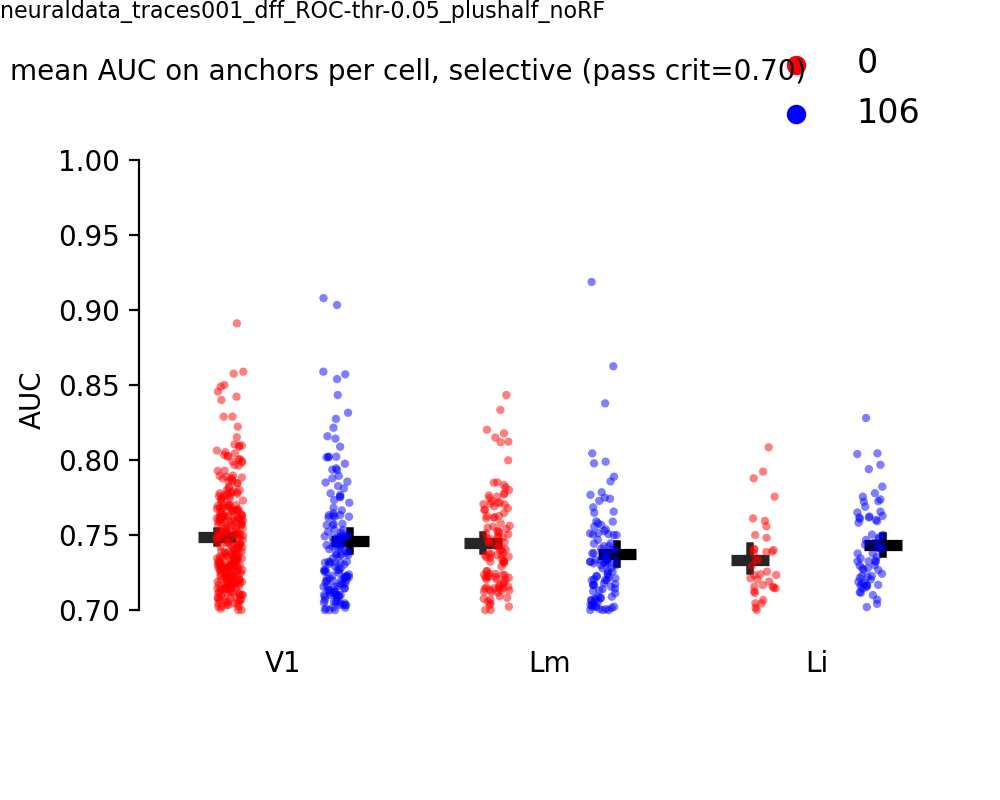

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.1477136475930195, 0.14772002848141771, 0.1476949000552352)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,


/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/AUC stripplot_auc_selective-crit-0.70


In [50]:
object_colors = {'A': 'r', 'B': 'b', 0:'r', 106: 'b'}
visual_areas=['V1', 'Lm', 'Li']
fig, ax = pl.subplots(figsize=(5,4), dpi=100)
sns.stripplot(x='visual_area', y='AUC', hue='Eff', data=meanAUC, ax=ax, #zorder=-1,
             dodge=0.5, palette=object_colors, alpha=0.5,size=3, order=visual_areas)
sns.pointplot(x='visual_area', y='AUC', hue='Eff', data=meanAUC, ax=ax,
             join=False, dodge=0.5, color='k', markers='_', order=visual_areas,
            scale=2) #zorder=-1,  scale=2)
ax.set_ylim([0.68, 1])
ax.tick_params(which='both', axis='x', size=0)
sns.despine(trim=True, offset=4, bottom=True)
ax.set_xlabel('')
fig.text(0.01, 0.9, 'mean AUC on anchors per cell, %s (pass crit=%.2f)' % (selective_str, criterion))
pplot.crop_legend_labels(ax, n_hues=2, bbox_to_anchor=(1,1), loc='lower right')
pl.subplots_adjust(left=0.15, right=0.95, bottom=0.2, top=0.8)
pplot.label_figure(fig, data_id)
figname = 'stripplot_auc_%s-crit-%.2f' % (selective_str, criterion)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [40]:
meanAUC

,visual_area,datakey,cell,Eff,AUC,morphlevel,size,n_trials
0,Li,20190422_JC076_fov1,119,0,0.750000,0.0,10.0,30.0
1,Li,20190422_JC076_fov1,194,106,0.720370,40.0,20.0,30.0
2,Li,20190422_JC076_fov1,261,106,0.804444,106.0,30.0,30.0
3,Li,20190422_JC076_fov1,292,106,0.737778,106.0,50.0,30.0
4,Li,20190422_JC076_fov1,296,106,0.765556,14.0,10.0,30.0
...,...,...,...,...,...,...,...,...
770,V1,20191006_JC110_fov1,310,0,0.749527,7.0,50.0,33.0
771,V1,20191006_JC110_fov1,338,106,0.748106,106.0,30.0,33.0
772,V1,20191006_JC110_fov1,353,106,0.763258,97.6,40.0,33.0
773,V1,20191006_JC110_fov1,364,106,0.719697,106.0,10.0,33.0


# Stats

In [41]:
import pingouin as pg

In [52]:
meanAUC['subject'] = np.arange(0, len(meanAUC))
meanAUC

,visual_area,datakey,cell,Eff,AUC,morphlevel,size,n_trials,subject
0,Li,20190422_JC076_fov1,119,0,0.750000,0.0,10.0,30.0,0
1,Li,20190422_JC076_fov1,194,106,0.720370,40.0,20.0,30.0,1
2,Li,20190422_JC076_fov1,261,106,0.804444,106.0,30.0,30.0,2
3,Li,20190422_JC076_fov1,292,106,0.737778,106.0,50.0,30.0,3
4,Li,20190422_JC076_fov1,296,106,0.765556,14.0,10.0,30.0,4
...,...,...,...,...,...,...,...,...,...
770,V1,20191006_JC110_fov1,310,0,0.749527,7.0,50.0,33.0,770
771,V1,20191006_JC110_fov1,338,106,0.748106,106.0,30.0,33.0,771
772,V1,20191006_JC110_fov1,353,106,0.763258,97.6,40.0,33.0,772
773,V1,20191006_JC110_fov1,364,106,0.719697,106.0,10.0,33.0,773


In [53]:
meanAUC.groupby(['visual_area', 'Eff']).count()

datakey  cell  AUC  morphlevel  size  n_trials  subject
visual_area Eff                                                         
Li          0         37    37   37          37    37        37       37
            106       67    67   67          67    67        67       67
Lm          0        115   115  115         115   115       115      115
            106      102   102  102         102   102       102      102
V1          0        305   305  305         305   305       305      305
            106      149   149  149         149   149       149      149

In [44]:
# Create a sample dataframe
# data = pd.DataFrame({
#     'dv': [10, 12, 15, 11, 13, 16, 18, 17, 20, 19],
#     'factor1': ['A', 'A', 'A', 'B', 'B', 'B', 'C', 'C', 'C', 'C'],
#     'factor2': ['X', 'Y', 'Z', 'X', 'Y', 'Z', 'X', 'Y', 'Z', 'X']
# })

# Perform the two-way ANOVA
aov = pg.anova(data=meanAUC, dv='AUC', 
               between=['visual_area', 'Eff'], detailed=True)
# aov = pg.mixed_anova(dv='AUC', within='Eff', between='visual_area', 
#                      subject='subject', data=meanAUC)
print(aov)

              Source        SS     DF        MS         F     p-unc       np2
0        visual_area  0.007910    2.0  0.003955  3.455147  0.032074  0.008906
1                Eff  0.001102    1.0  0.001102  0.962371  0.326899  0.001250
2  visual_area * Eff  0.004942    2.0  0.002471  2.158843  0.116158  0.005583
3           Residual  0.880232  769.0  0.001145       NaN       NaN       NaN


In [45]:
# Run pairwise comparisons for the visual area factor
posthoc = pg.pairwise_tests(
    dv='AUC', between='visual_area', data=meanAUC, padjust='bonferroni'
)
print(posthoc)

      Contrast   A   B  Paired  Parametric         T         dof alternative  \
0  visual_area  Li  Lm   False        True -0.403317  241.127847   two-sided   
1  visual_area  Li  V1   False        True -2.554588  193.542209   two-sided   
2  visual_area  Lm  V1   False        True -2.382160  459.129708   two-sided   

      p-unc    p-corr    p-adjust   BF10    hedges  
0  0.687072  1.000000  bonferroni  0.142 -0.044926  
1  0.011400  0.034201  bonferroni  2.713 -0.234331  
2  0.017618  0.052853  bonferroni  1.451 -0.190665  


In [66]:
meanAUC['subject'] = meanAUC['subject'].astype('category')
meanAUC['Eff'] = meanAUC['Eff'].astype('category')
meanAUC['visual_area'] = meanAUC['visual_area'].astype('category')
meanAUC['AUC'] = pd.to_numeric(meanAUC['AUC'], errors='coerce')

In [67]:
print(meanAUC.groupby(['subject', 'Eff']).size())


subject  Eff
0        0      0
         106    1
1        0      0
         106    1
2        0      0
               ..
864      106    1
865      0      0
         106    1
866      0      0
         106    1
Length: 1734, dtype: int64
